<a href="https://colab.research.google.com/github/tim108108/qcn/blob/master/calssified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow==2.4.1
!pip install -q tensorflow_quantum
!pip install -q cirq

In [3]:
import cirq,random,sympy
import numpy as np
import tensorflow as tf
import tensorflow_quantum as tfq
from tensorflow import keras
import matplotlib.pyplot as plt


qubit = cirq.GridQubit(0,0)
# Qutum data labels
expected_labels = np.array([[1, 0],[0, 1]])

# Random rotation of X and Z axes
angle = np.random.uniform(0, 2 * np.pi)

# Build the quantum data 
a = cirq.Circuit(cirq.ry(angle)(qubit))
b = cirq.Circuit(cirq.ry(angle + np.pi/2)(qubit))
quantum_data = tfq.convert_to_tensor([a, b])

# Build the quantum model
q_data_input=tf.keras.Input(shape=(), dtype=tf.dtypes.string)

theta = sympy.Symbol('theta')
q_model = cirq.Circuit(cirq.ry(theta)(qubit))

expectation = tfq.layers.PQC(q_model, cirq.Z(qubit))
expectation_output = expectation(q_data_input)

# Attach the classical SoftMax classifier
classifier = tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
classifier_ouput = classifier(expectation_output)

# Train the hybrid model
model = tf.keras.Model(inputs=q_data_input,
            outputs=classifier_ouput)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss=tf.keras.losses.CategoricalCrossentropy())
history = model.fit(x=quantum_data, y=expected_labels,
            epochs=250, verbose=0)

In [4]:
#Check inference on nosiy quantum datapoints
noise = np.random.uniform(-0.25, 0.25, 2)
test_data = tfq.convert_to_tensor([
          cirq.Circuit(
            cirq.ry(angle + noise[0])(qubit)),
          cirq.Circuit(
            cirq.ry(angle + noise[1] + np.pi/2)(qubit))
        ])
predictions = model.predict(test_data)

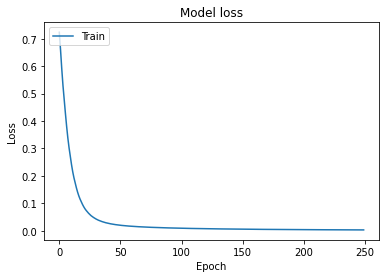

In [5]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()